In [316]:
import numpy as np
import gpstk
import random
from Toolkit_GNSS import *
import matplotlib.pyplot as plt
%matplotlib inline

##Stations

In [317]:
#Station 1 Rinex Files, Station 2 Rinex Files, PRN Satellite
#station=[["/mnt/zob1324.03.n","/mnt/zob1324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 8"]
#station=[["/mnt/erla324.03.n","/mnt/erla324.03.o"],["/mnt/leba324.03.n","/mnt/leba324.03.o"],"GPS 28"]
#station=[["/mnt/woos324.03.n","/mnt/woos324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 26"]
#station=[["/mnt/freo324.03.n","/mnt/freo324.03.o"],["/mnt/lsbn324.03.n","/mnt/lsbn324.03.o"],"GPS 26"]
#station=[["/mnt/erla324.03.n","/mnt/erla324.03.o"],["/mnt/grtn324.03.n","/mnt/grtn324.03.o"],"GPS 28"]
station=[["/mnt/colb324.03.n","/mnt/colb324.03.o"],["/mnt/mtvr324.03.n","/mnt/mtvr324.03.o"],"GPS 26"]


# Step 1) Get observations Data (Carrier Phase, Code, Times, etc.)

In [318]:
st1,st2,satellite=station[0],station[1],station[2]
t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2,L11,L12,L21,L22,C11,C12,C21,C22,Tgd =getdata_stationpair(st1,st2,satellite)

In [319]:
print type(t1),type(Icode1),type(Iphase1)

<type 'list'> <type 'dict'> <type 'dict'>


#Step 2) Separate into arcs

Observations separated for more than an hour it's sonsidered a new arc. So the information is divided: **carrier phase, code, elevation and IPP's. **

In [320]:
def get_arcs(t,Icode,Iphase,ELEV,IPPS,L1,L2,C1,C2): 
    #Returns arcs with observations time, phase & code delay,IPP
    #For every station returns a dictionary
    ##key: Number of arc observed in that day (starting with 0).
    ##values: Phase, Code, etc in that arc
    Phase,Code,Elevation=[],[],[]
    PhaseL1,PhaseL2=[],[]
    CodeL1,CodeL2,IPP=[],[],[]
    notfound=0 
    a=[]
    
    for i in t:
        if i in Iphase.keys(): #all times in t should correspond to the keys in the dictionaries.
            Phase.append(Iphase[i])
            Code.append(Icode[i])
            Elevation.append(ELEV[i])
            PhaseL1.append(L1[i])
            PhaseL2.append(L2[i])
            CodeL1.append(C1[i])
            CodeL2.append(C2[i])
            IPP.append(IPPS[i])
        else:
            #print "Tiempo no encontrado: ",i
            notfound+=1
            
    if notfound>0:
        print "Tiempos no encontrados :",notfound
    
    t=adjust_times(t)
    
    Phase,Code,t,Elevation,PhaseL1,PhaseL2,CodeL1,CodeL2=np.array(Phase),np.array(Code),np.array(t),np.array(Elevation),np.array(PhaseL1),np.array(PhaseL2),np.array(CodeL1),np.array(CodeL2)
    
    limits=[]
    for i in range(1,len(t)):
        if t[i]-t[i-1]>3600: 
            limits.append(i)

    arcs=np.split(range(t.size),limits)
    obs={} #Key: Number arc, Values: array time of observations , arrayPhase Delays, array code etc.
    i=0
    for arc in arcs:
        obs[i]=[t[arc],Phase[arc],Code[arc],Elevation[arc],PhaseL1[arc],PhaseL2[arc],CodeL1[arc],CodeL2[arc]]
        i+=1
    return obs

In [321]:
arcs_St1=get_arcs(t1,Icode1,Iphase1,ELEV1,IPP1,L11,L12,C11,C12) #gets arcs with Phase, Code, and adjusted times observations
arcs_St2=get_arcs(t2,Icode2,Iphase2,ELEV2,IPP2,L21,L22,C21,C22)
len(arcs_St1),len(arcs_St2)

(2, 2)

##On station 1: First arc, there are'nt  big gradients

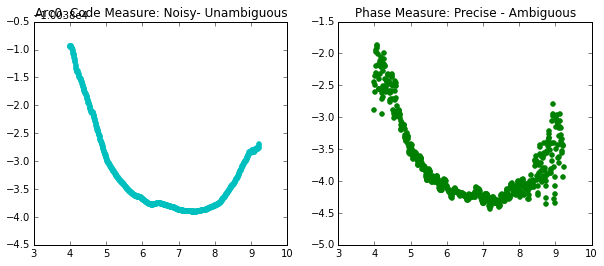

In [322]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Arc0: Code Measure: Noisy- Unambiguous")
plt.scatter(arcs_St1[0][0]/3600,arcs_St1[0][1],color="c")
plt.subplot(1,2,2)
plt.title("Phase Measure: Precise - Ambiguous")
plt.scatter(arcs_St1[0][0]/3600,arcs_St1[0][2],color="g")

##On station 1: Second arc. More ionospheric activity, bias, slips...

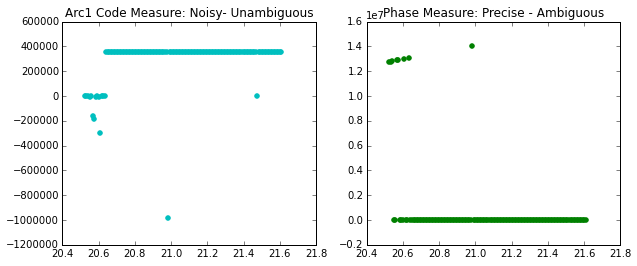

In [323]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Arc1 Code Measure: Noisy- Unambiguous")
plt.scatter(arcs_St1[1][0]/3600,arcs_St1[1][1],color="c")
plt.subplot(1,2,2)
plt.title("Phase Measure: Precise - Ambiguous")
plt.scatter(arcs_St1[1][0]/3600,arcs_St1[1][2],color="g")

#Step 3) Cycle slip detection for only 1 arc (second arc in the day)
On days with strong ionospheric activity the threshold is more flexible (bigger) 2.5 meters, normal days with 0.5 meters, that way we avoid confusing gradients with cycle slips

In [324]:
arc=1#second 
if arc in arcs_St1 and arc in arcs_St2:
    print "\n*************Arc #"+str(arc+1)+"*************"
    time1=arcs_St1[arc][0] 
    time2=arcs_St2[arc][0] 

    tboth=np.intersect1d(time1,time2)
    print "\n# Times in common: ",tboth.size
    
    #Now we take observations in both stations
    t1index=np.array([i for i in range(time1.size) if time1[i] in tboth ])
    t2index=np.array([i for i in range(time2.size) if time2[i] in tboth ])
    print "IndexT1 type",type(t1index)
    print t1index.shape

    time1,time2=time1[t1index],time2[t2index]
    Phase1,Phase2=arcs_St1[arc][1][t1index],arcs_St2[arc][1][t2index]
    Code1,Code2=arcs_St1[arc][2][t1index],arcs_St2[arc][2][t2index]
    Elevation1,Elevation2=arcs_St1[arc][3][t1index],arcs_St2[arc][3][t2index]

    #Phase on frequency L1,L2 station1
    Phase1L1,Phase1L2=arcs_St1[arc][4][t1index],arcs_St1[arc][5][t1index]
    Code1L1,Code1L2=arcs_St1[arc][6][t1index],arcs_St1[arc][7][t1index]

    #Phase and Code on frequency L1,L2 station 2
    Phase2L1,Phase2L2=arcs_St2[arc][4][t2index],arcs_St2[arc][5][t2index]
    Code2L1,Code2L2=arcs_St2[arc][6][t2index],arcs_St2[arc][7][t2index]
   
    #Ionospheric pearce points
    DIPP1=getIPPS(IPP1,tboth)
    DIPP2=getIPPS(IPP2,tboth)
    
    D=[]
    for i in tboth:
        d=np.sqrt((DIPP1[i][0]-DIPP2[i][0])**2+(DIPP1[i][1]-DIPP2[i][1])**2+(DIPP1[i][2]-DIPP2[i][2])**2)
        D.append(d)

    D=np.array(D)
  


*************Arc #2*************

# Times in common:  126
IndexT1 type <type 'numpy.ndarray'>
(126,)


In [325]:
def datajump(lI,threshold=0.5): #Input: lI=L1-L2, times. Detects jumps in data depending on a threshold
    #retorna los indices 
    jumps=[]
    jumps=np.where(np.abs(np.diff(np.hstack(([0],lI))))>threshold) 
    return jumps[0] 
    

In [326]:
jumps1=datajump(Phase1,2.5)
jumps2=datajump(Phase2,2.5)


In [327]:
jumps1

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  13,  53,  54,  55,
       113, 114])

In [328]:
def plot_slip(jumps,phase,time,xlim1=None,xlim2=None,ylim1=None,ylim2=None,jumpsMP=None):
    timejumps=time[jumps]
    phasejumps=phase[jumps]
    #plt.figure()
    plt.scatter(time,phase,color="yellow" ,label="Normal points") #points
    plt.scatter(timejumps,phasejumps,color="#ff3300",label="Jumps")
    if jumpsMP!=None and len(jumpsMP)>0:
        timeMP=time[jumpsMP]
        phaseMP=phase[jumpsMP]
        plt.scatter(timeMP,phaseMP,color="blue",label="Multipass Jumps") #points of MP cycle slip
        plt.scatter(timeMP,phaseMP,color="blue",label="Multipass Jumps") 
    plt.legend()
    plt.xlabel("Time [second of the day]")
    plt.ylabel("Phase delay in one station [meters]")
    plt.ylim(ylim1,ylim2) #there is a huge cycle slip in this specific arc, this makes apreciate detail jumps


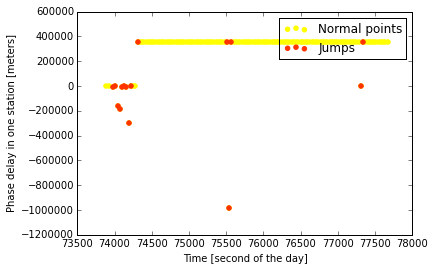

In [329]:
plot_slip(jumps1,Phase1,time1,None,None,None,None,jumpsMP=None)
#-30,30


#Step 4) Divide continuos arcs into sub arcs
Using the slips detected we  proceed to dicvide arcs into mini arcs, this part is important for later phase leveling.

In [330]:
def sub_arcs(lI,jumps): #returns intervals of each sub-arc inside an arc (indices)
    miniarcs=np.split(range(lI.size),jumps)
    return miniarcs

In [331]:
miniarcs1=sub_arcs(Phase1,jumps1)
miniarcs2=sub_arcs(Phase2,jumps2)

In [332]:
def plotsubarcs(time,Phase,miniarcs,xlim1=None,xlim2=None,ylim1=None,ylim2=None):
    plt.figure()
    for i in miniarcs:
        color = "#%06x" % random.randint(0, 0xFFFFFF)
        plt.scatter(time[i],Phase[i],color=color)
        #plt.ylim(-50,50)
        

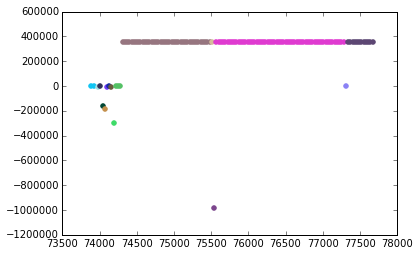

In [333]:
plotsubarcs(time1,Phase1,miniarcs1,None,None,-50,50)

**Note:** At this point we can see there are some arcs, with very few points. And smetimes this may match some of the slips earlier detected. Next step is to eliminate arcs with less than 10 pints or five minutes because according to Lee's [2020] **"The leveling error of very short arcs is
typically large and thus make delay estimates useless."**

#Step 5) Discard subarcs of less than 10 points or 5 minutes 

In [334]:
#Remove short arcs 
if len(jumps1)>0:
    miniarcs1,miniarcs2=remove_short(miniarcs1,miniarcs2)
if len(jumps2)>0:
    miniarcs2,miniarcs1=remove_short(miniarcs2,miniarcs1)
    

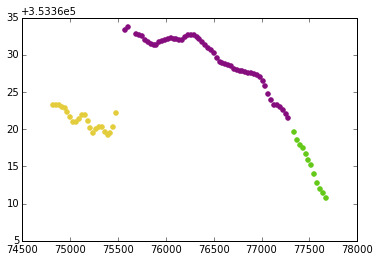

In [335]:
plotsubarcs(time1,Phase1,miniarcs1,None,None,None,None)

#Step 6) Outliers Detection

In [336]:
def poly_fit(lI,time):
    #takes N elements from LI=L1-L2 and performs interpolation, 
    #detects datajumps in the diference between the polinomyal fit and real data 
    N=10 #window 
    tPoly ,Poly=[],[]
    
    for i in range(0,lI.size,N): 
        x=np.array(time[i:i+N])
        y=np.array(lI[i:i+N])
        z= np.polyfit(x,y,2)
        p = np.poly1d(z)
        for i in range(x.size):
            Poly.append(p(x[i]))
            tPoly.append(x[i]) 
    Poly=np.array(Poly)
    residual=lI-Poly
    jumps=datajump(residual,0.8)
    if jumps.size>0:
        pslip=np.argmax(residual[jumps])
        pslip=jumps[pslip]
    else:
        pslip=None
    return Poly,pslip

def outlier_detect(L,times,k=10):#k=30? 15 min
    outliers=[] #set of outlier factors for every element in L=L1-L2
    for i in range(0,L.size):
        if i<(k/2+1):
            neighbours=np.hstack((L[0:i],L[i+1:i+(k/2)+1])) #neighbours around i, without i
            tn=np.hstack((times[0:i],times[i+1:i+(k/2)+1]))
    
        elif i>L.size-(k/2+1):
            neighbours=np.hstack((L[i-k/2:i],L[i+1:L.size+1]))
            tn=np.hstack((times[i-k/2:i],times[i+1:L.size+1])) #times neighbour
            
        else:
            neighbours=np.hstack((L[i-k/2:i],L[i+1:i+(k/2)+1]))
            tn=np.hstack((times[i-k/2:i],times[i+1:i+(k/2)+1]))
        
        OFt=0
        deno=np.sum(1/(np.abs(times[i]-tn)*1.0))#denominador de Wpq para elemento i
        for neighbour in range(neighbours.size): 
            if times[neighbour]!=times[i]:
                Wpq=1/np.abs(times[i]-times[neighbour])
                Wpq=Wpq/deno
                OFt+=(Wpq*np.abs(L[i]-L[neighbour]))
        outliers.append(OFt) 
    
    outliers=np.array(outliers)
    if len(outliers)!=0:
        oslip=np.argmax(outliers) #term with biggest outlier factor
    else:
        oslip=None
    
    return outliers,oslip

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


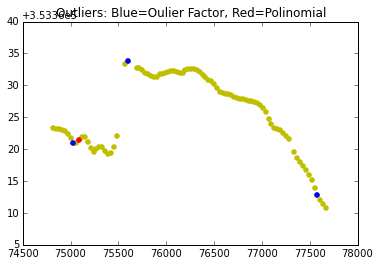

In [337]:
pslips1=[] #slips in st1 with polinomyal fit
oslips1=[] #slips in st1 oulier factor

pslips2=[] 
oslips2=[]

for i in range(len(miniarcs1)):#In station1
    __,pslip=poly_fit(Phase1[miniarcs1[i]],time1[miniarcs1[i]])
    pslips1.append(pslip)
    plt.title("Outliers: Blue=Oulier Factor, Red=Polinomial")
    plt.scatter(time1[miniarcs1[i]],Phase1[miniarcs1[i]],color="y")
    if pslip!=None:
        plt.scatter(time1[miniarcs1[i]][pslip],Phase1[miniarcs1[i][pslip]],color="r")
    __,oslip=outlier_detect(Phase1[miniarcs1[i]],time1[miniarcs1[i]]*3600)
    oslips1.append(oslip)
    plt.scatter(time1[miniarcs1[i]][oslip],Phase1[miniarcs1[i][oslip]],color="b")
    plt.legend()
    


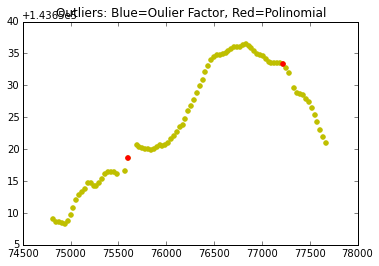

In [338]:
for i in range(len(miniarcs2)):#In station2
    __,pslip=poly_fit(Phase2[miniarcs2[i]],time2[miniarcs2[i]])
    pslips2.append(pslip)
    plt.title("Outliers: Blue=Oulier Factor, Red=Polinomial")
    plt.scatter(time2[miniarcs2[i]],Phase2[miniarcs2[i]],color="y")
    if pslip!=None:
        plt.scatter(time2[miniarcs2[i]][pslip],Phase2[miniarcs2[i][pslip]],color="r")
    __,oslip=outlier_detect(Phase2[miniarcs2[i]],time2[miniarcs2[i]]*3600)
    oslips2.append(oslip)

##Outliers are confirmed and removed

In [339]:
def confirmed_slip(t,L):
    #if the biggest slip computed with polifit and outlier factor is the same an outlier is confirmed
    Poly,pslip=poly_fit(L,t)
    confirmed=[]
    while len(Poly)!=0: #if there are outliers
        __,oslip=outlier_detect(L,t*3600) 
        if pslip==oslip and pslip not in confirmed and pslip!=None: 
            confirmed.append(pslip) 
            L=np.delete(L,pslip) #remove outlier so it kepps looking for new different outliers
            t=np.delete(t,pslip)
            print "Poly: ",pslip,"Outlier factor: ",oslip
        Poly,npslip=poly_fit(L,t)  
        if npslip==pslip:
            break
        else:
            pslip=npslip
    return confirmed
    
    
def remove_slip(miniarcs1,miniarcs2,oslip1): #deletes confirmed slip
    elim=miniarcs1[oslip1]
    #print "Delete index: ",elim
    for subarc in range(len(miniarcs2)):
        if elim in miniarcs2[subarc]:
            i=np.where(miniarcs2[subarc]==elim)
            #print miniarcs2[subarc]
            miniarcs2[subarc]=np.delete(miniarcs2[subarc],i)
            #print miniarcs2[subarc]
    miniarcs1=np.delete(miniarcs1,oslip1)
    
    return miniarcs1,miniarcs2

0
[]


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


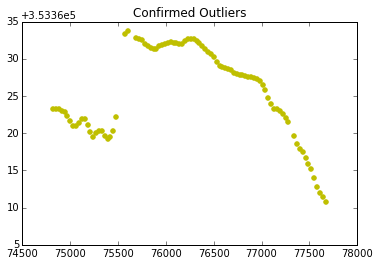

In [340]:
confirmed1=[]
for i in range(len(miniarcs1)):
    outliers=confirmed_slip(time1[miniarcs1[i]],Phase1[miniarcs1[i]])
    plt.scatter(time1[miniarcs1[i]],Phase1[miniarcs1[i]],color="y")
    plt.title("Confirmed Outliers")
    #this is not in the Tolkit script and dhpuld be added
    if len(outliers)!=0:
        plt.scatter(time1[miniarcs1[i]][outliers],Phase1[miniarcs1[i][outliers]],color="red")
        confirmed1.append(outliers)
print len(confirmed1) 
print confirmed1

0
[]


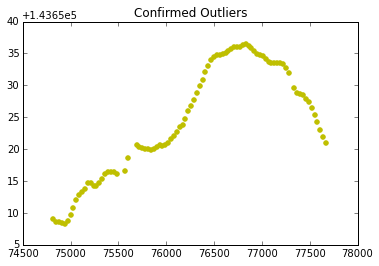

In [341]:
confirmed2=[]
for i in range(len(miniarcs2)):
    outliers=confirmed_slip(time2[miniarcs2[i]],Phase2[miniarcs2[i]])
    plt.scatter(time2[miniarcs2[i]],Phase2[miniarcs2[i]],color="y")
    plt.title("Confirmed Outliers")
    #this is not in the Tolkit script and dhpuld be added
    if len(outliers)!=0:
        plt.scatter(time2[miniarcs2[i]][outliers],Phase2[miniarcs2[i][outliers]],color="red")
        confirmed1.append(outliers)
print len(confirmed2) 
print confirmed2

In [342]:
for i in range(len(confirmed1)):
    if len(confirmed1[i])!=0:
        miniarcs1[i],miniarcs2=remove_slip(miniarcs1[i],miniarcs2,oslips1[i])

for i in range(len(confirmed2)):
    if len(confirmed2[i])!=0:
        miniarcs2[i],miniarcs1=remove_slip(miniarcs2[i],miniarcs1,oslips2[i])

#Step 7) Carrier smoothing of the code usin Hatch filter

In [343]:
def Smooth_code(R,L):
    size=R.size
    N=100
    #size/2
    for k in range(1,size):
        if k>N:
            n=N
        else:
            n=k
        R[k]=L[k]+((n-1.0)/n)*(R[k-1]-L[k-1])+(1.0/n)*(R[k]-L[k])
    return R

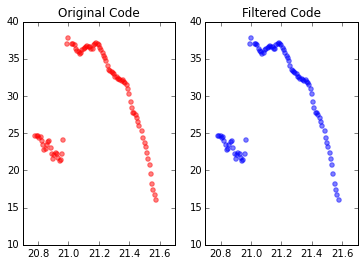

In [344]:
newC1,newC2=Code1,Code2
for i in range(len(miniarcs1)):
    newC1[miniarcs1[i]]=Smooth_code(Code1[miniarcs1[i]],Phase1[miniarcs1[i]])
    #plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Code")
    plt.scatter(time1[miniarcs1[i]]/3600,Code1[miniarcs1[i]], color="red",alpha=.5)
    plt.subplot(1,2,2)
    plt.title("Filtered Code")
    plt.scatter(time1[miniarcs1[i]]/3600,newC1[miniarcs1[i]], color="blue",alpha=.5)



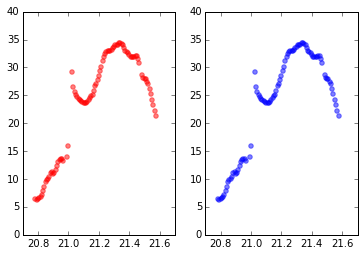

In [345]:
for i in range(len(miniarcs2)):
    newC2[miniarcs2[i]]=Smooth_code(Code2[miniarcs2[i]],Phase2[miniarcs2[i]])
    #plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(time2[miniarcs2[i]]/3600,Code2[miniarcs2[i]], color="red",alpha=.5)
    plt.subplot(1,2,2)
    plt.scatter(time2[miniarcs2[i]]/3600,newC2[miniarcs2[i]], color="blue",alpha=.5)

#Step 8) Phase Leveling Using code

In [346]:
def levelphase(ICODE,IPHASE,ELEV): 
    L=np.sum((ICODE-IPHASE)*(np.sin(ELEV)**2))/np.sum((np.sin(ELEV))**2) #leveling factor
    new_IPHASE=IPHASE+L
    return L,new_IPHASE

In [347]:
PhaseArc1=[] #list with subarcs leveled
PhaseArc2=[]
C1,C2=[],[]
IPPD=[]

for i in range(len(miniarcs1)):
    Lfactor,new_IPHASE_arc=levelphase(newC1[miniarcs1[i]],Phase1[miniarcs1[i]],Elevation1[miniarcs1[i]])
    PhaseArc1.append(new_IPHASE_arc)  
    C1.append(newC1[miniarcs1[i]])
    IPPD.append(D[miniarcs1[i]])
    
for i in range(len(miniarcs2)):
    Lfactor,new_IPHASE_arc=levelphase(newC2[miniarcs2[i]],Phase2[miniarcs2[i]],Elevation2[miniarcs2[i]])
    PhaseArc2.append(new_IPHASE_arc)
    C2.append(newC2[miniarcs2[i]])

#Now we merge all subarcs into one arc
new_IPHASE_arc1,new_IPHASE_arc2=np.hstack(PhaseArc1),np.hstack(PhaseArc2)
C1,C2=np.hstack(C1),np.hstack(C2)
IPPD=np.hstack(IPPD)
ntimes1,ntimes2=np.array([]),np.array([])

for i in miniarcs1:
    ntimes1=np.append(ntimes1,time1[i])
for i in miniarcs2:ntimes2=np.append(ntimes2,time2[i])

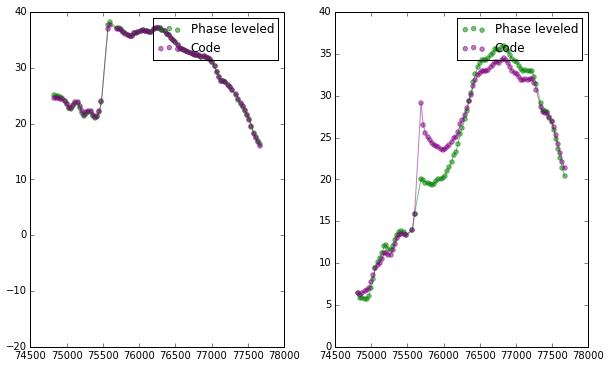

In [351]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.scatter(ntimes1,new_IPHASE_arc1,alpha=.5,color="green",label="Phase leveled")
plt.plot(ntimes1,new_IPHASE_arc1,alpha=.5,color="green")
plt.scatter(ntimes1,C1,alpha=.5,label="Code",color="purple")
plt.plot(ntimes1,C1,alpha=.5,color="purple")
plt.ylim(-20,40)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(ntimes2,new_IPHASE_arc2,alpha=.5,color="green",label="Phase leveled")
plt.plot(ntimes2,new_IPHASE_arc2,alpha=.5,color="green")
plt.scatter(ntimes2,C2,alpha=.5,label="Code",color="purple")
plt.plot(ntimes2,C2,alpha=.5,color="purple")
#plt.ylim(-20,40)
plt.legend()

#Step 8) TGD and IFB estimation

#Step 9) Gradient 

In [349]:
d=IPPD/1000 #Km
IONO_Phase=(new_IPHASE_arc1-new_IPHASE_arc2)*1000/d #mm
IONO_Code=(C1-C2)*1000/d


Biggest grdient Carrier:  384.139207539
Time of biggest gradient:  20.9916666667


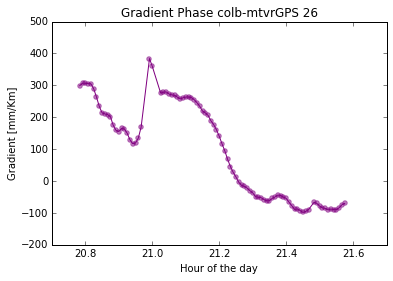

In [350]:
plt.figure()
#plt.subplot(2,2,1)
title="Gradient Phase "+st1[0][5:9]+"-"+st2[0][5:9]+satellite
plt.title(title)
plt.xlabel("Hour of the day")
plt.ylabel("Gradient [mm/Km]")
plt.scatter(ntimes2/3600,IONO_Phase,color="purple",alpha=0.5)
plt.plot(ntimes2/3600,IONO_Phase,color="purple")
print "Biggest grdient Carrier: ",np.max(IONO_Phase)
print "Time of biggest gradient: ",ntimes2[np.argmax(IONO_Phase)]/3600